## Guided LDA

https://gist.github.com/scign/2dda76c292ef76943e0cd9ff8d5a174a

"eta" parameter i LDAModel

In [1]:
import os
import pandas as pd
import json
import re
import numpy as np

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [2]:
data_path = os.path.join('/work', 'dl2020_horesta-scraper', 'data')
datawork_path = os.path.join('/work', 'dl2020_horesta-scraper', 'data', 'work')
out_path = os.path.join('/work', 'dl2020_horesta-scraper', 'output')

filename_in = 'horesta_posts_2021-03-25_tokenized.json'

In [3]:
# Loading data
path = os.path.join(datawork_path, filename_in)

with open(path, 'r') as file:
    data = json.load(file)

In [6]:
# Corpus objects

id2token = corpora.Dictionary([entry.get('tokens') for entry in data])

tokens_bow = [entry.get('doc2bow') for entry in data]
tokens_tfidf = [entry.get('tfidfbow') for entry in data]
corpus_texts = [entry.get('tokens') for entry in data]

In [7]:
n_topics = 7
chunksize = 2000
passes = 20
iterations = 500

model_auto = gensim.models.LdaModel(corpus = tokens_bow, 
                                    num_topics = n_topics, 
                                    id2word = id2token, 
                                    chunksize = chunksize, 
                                    passes = passes, 
                                    iterations = iterations, 
                                    random_state = 1332,
                                    eval_every = 1,
                                    update_every = 1,
                                    alpha = "auto",
                                    eta = "auto",
                                    per_word_topics = True)

In [8]:
coherence_model_lda = CoherenceModel(model=model_auto, corpus=tokens_bow, coherence='u_mass')
print(coherence_model_lda.get_coherence())

-1.5702012501529559


In [9]:
from pprint import pprint 

# Show Topics
pprint(model_auto.show_topics(formatted=False, num_topics=n_topics))

[(0,
  [('virksomhed', 0.026282413),
   ('erhverv', 0.014169432),
   ('komme', 0.010317038),
   ('politisk', 0.009341644),
   ('direktør', 0.00919279),
   ('regering', 0.008623649),
   ('mangen', 0.007796187),
   ('restriktion', 0.0074669304),
   ('medarbejder', 0.0068995226),
   ('omsætning', 0.00679778)]),
 (1,
  [('hotel', 0.014732303),
   ('bæredygtig', 0.010219284),
   ('ferie', 0.007593608),
   ('årsdag', 0.0068112346),
   ('komme', 0.005845455),
   ('virksomhed', 0.005498592),
   ('finde', 0.0054399497),
   ('bæredygtighed', 0.005420482),
   ('udvikling', 0.0053018276),
   ('email', 0.005258194)]),
 (2,
  [('virksomhed', 0.024822267),
   ('email', 0.009612754),
   ('protected', 0.009583493),
   ('yderlig', 0.009245197),
   ('direktør', 0.008892612),
   ('kontakt', 0.00880598),
   ('information', 0.008639136),
   ('kontaktkort', 0.008122357),
   ('mulighed', 0.0076398584),
   ('fortælle', 0.007276478)]),
 (3,
  [('hotel', 0.021550318),
   ('virksomhed', 0.013859305),
   ('overnat

In [94]:
for t in range(n_topics):
    if "økonomisk" in [word for word, prop in model_auto.show_topic(t, topn = 100)]:
        print(t)

0
2


In [72]:
for t in range(n_topics):
    print(t)

0
1
2
3
4
5
6


In [22]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return(eta)

In [10]:
print(1e7)

10000000.0


In [11]:
eta = np.full(shape=(n_topics, len(id2token)), fill_value=1)

In [16]:
keyindex = [index for index,term in id2token.items() if term=="bæredygtig"]
if len(keyindex) > 0:
    eta[1, keyindex[0]] = 1e7


In [19]:
eta = np.divide(eta, eta.sum(axis=0))
eta[1, keyindex[0]]

0.99999940000036

In [20]:
apriori = {
    "bæredygtig": 1,
    "bæredygtighed": 1,
    "miljøchef": 1,
    "corona": 5,
    "coronavirus": 5,
    "coronavirussen": 5,
    "coronakrisen": 5,
    "restriktion": 5,
    "genåbning": 5, 
    "forsamlingsforbuddet": 5,
    "hjælpepakke": 5,
    "mundbind": 5, 
    "nedlukning": 5,
    "statsminister": 0,
    "politiker": 0,
    "regering": 0,
    "politisk": 0
}

In [23]:
eta = create_eta(apriori, id2token, 7)

In [43]:
n_topics = 7
chunksize = 2000
passes = 20
iterations = 500

model_apriori = gensim.models.LdaModel(corpus = tokens_bow, 
                                    num_topics = n_topics, 
                                    id2word = id2token, 
                                    chunksize = chunksize, 
                                    passes = passes, 
                                    iterations = iterations, 
                                    random_state = 1332,
                                    eval_every=-1, 
                                    update_every=1,
                                    alpha = "auto",
                                    eta = eta)

In [44]:
coherence_model_lda = CoherenceModel(model=model_apriori, corpus=tokens_bow, coherence='u_mass')
print(coherence_model_lda.get_coherence())

-1.5644426489223047


In [45]:
from pprint import pprint 

# Show Topics
pprint(model_apriori.show_topics(formatted=False, num_topics=n_topics))

[(0,
  [('virksomhed', 0.026324872),
   ('erhverv', 0.014128233),
   ('komme', 0.01032078),
   ('politisk', 0.009411349),
   ('direktør', 0.009197246),
   ('regering', 0.00866246),
   ('mangen', 0.007767081),
   ('restriktion', 0.0073280735),
   ('medarbejder', 0.006914942),
   ('omsætning', 0.006767756)]),
 (1,
  [('hotel', 0.014679391),
   ('bæredygtig', 0.010722063),
   ('ferie', 0.007575146),
   ('årsdag', 0.006793771),
   ('komme', 0.005846649),
   ('bæredygtighed', 0.0056955917),
   ('virksomhed', 0.0055253077),
   ('finde', 0.005483799),
   ('udvikling', 0.0052942275),
   ('arbejde', 0.0052896175)]),
 (2,
  [('virksomhed', 0.024827883),
   ('email', 0.009609765),
   ('protected', 0.009580221),
   ('yderlig', 0.00924381),
   ('direktør', 0.008905374),
   ('kontakt', 0.008802372),
   ('information', 0.008630605),
   ('kontaktkort', 0.008116501),
   ('mulighed', 0.0076577105),
   ('fortælle', 0.0072594928)]),
 (3,
  [('hotel', 0.021545142),
   ('virksomhed', 0.013866786),
   ('over

In [46]:
# Add topic probabilities to data

for entry in data:
    entry['lda'] = model_apriori[entry.get('doc2bow')]

In [47]:
# Filter out variables

data_select = []
keys_select = ['url', 'accessed', 'title', 'tags', 'publish_date', 'access_date', 'text', 'tokens', 'lda']

for entry in data:
    entry_filtered = dict()
    for k,v in entry.items():
        if k in keys_select:
            entry_filtered[k] = v
    
    data_select.append(entry_filtered)

In [48]:
# Converting data to data frame

df = pd.DataFrame.from_records(data_select)

In [49]:
# Spreading topics across rows

df_topiclong = df.explode('lda').reset_index(drop = True)

In [50]:
# Splitting topic and probabilities into columns

df_topiclong = df_topiclong.assign(**pd.DataFrame(df_topiclong['lda'].tolist(), columns = ['topic', 'topic_prob']))

In [51]:
df_topiclong.head(10)

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.9978296)",0,0.997830
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(0, 0.43739045)",0,0.437390
2,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(2, 0.5605425)",2,0.560543
3,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(0, 0.9983259)",0,0.998326
4,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(2, 0.5536471)",2,0.553647
5,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(3, 0.4409755)",3,0.440975
6,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(2, 0.72169816)",2,0.721698
7,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(6, 0.273383)",6,0.273383
8,https://horesta.dk/nyheder/2020/december/uvish...,1,Uvished og manglende hjælp giver de største pa...,"[hotelerhvervet, restauranterhvervet, coronakr...",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nLandets hoteller og restaurant...,"[landets, hotel, restaurant, fremtid, kigge, f...","(0, 0.99849176)",0,0.998492
9,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA har lavet en rabataftale til indkøb af...,[],01-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nGenopliv.dk tilbyder værnemidl...,"[genoplivdk, tilbyde, værnemiddel, fordelagtig...","(4, 0.22850715)",4,0.228507


In [52]:
# Mean topic probability across data

df_topiclong.groupby('topic')['topic_prob'].mean()

topic
0    0.605882
1    0.479868
2    0.530240
3    0.469367
4    0.540746
5    0.506076
6    0.516329
Name: topic_prob, dtype: float64

In [53]:
# Date variables

df_topiclong['publish_date'] = pd.to_datetime(df_topiclong['publish_date'], format = '%d-%m - %Y')

df_topiclong['post_month'] = df_topiclong['publish_date'].dt.month
df_topiclong['post_year'] = df_topiclong['publish_date'].dt.year
df_topiclong['year_month'] = df_topiclong['publish_date'].apply(lambda x: str(x)[0:7])

In [54]:
# Topics over time

df_topictime_grouped = df_topiclong.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index() # Counting
df_topictime['topic'] = df_topictime['topic'].astype('category')

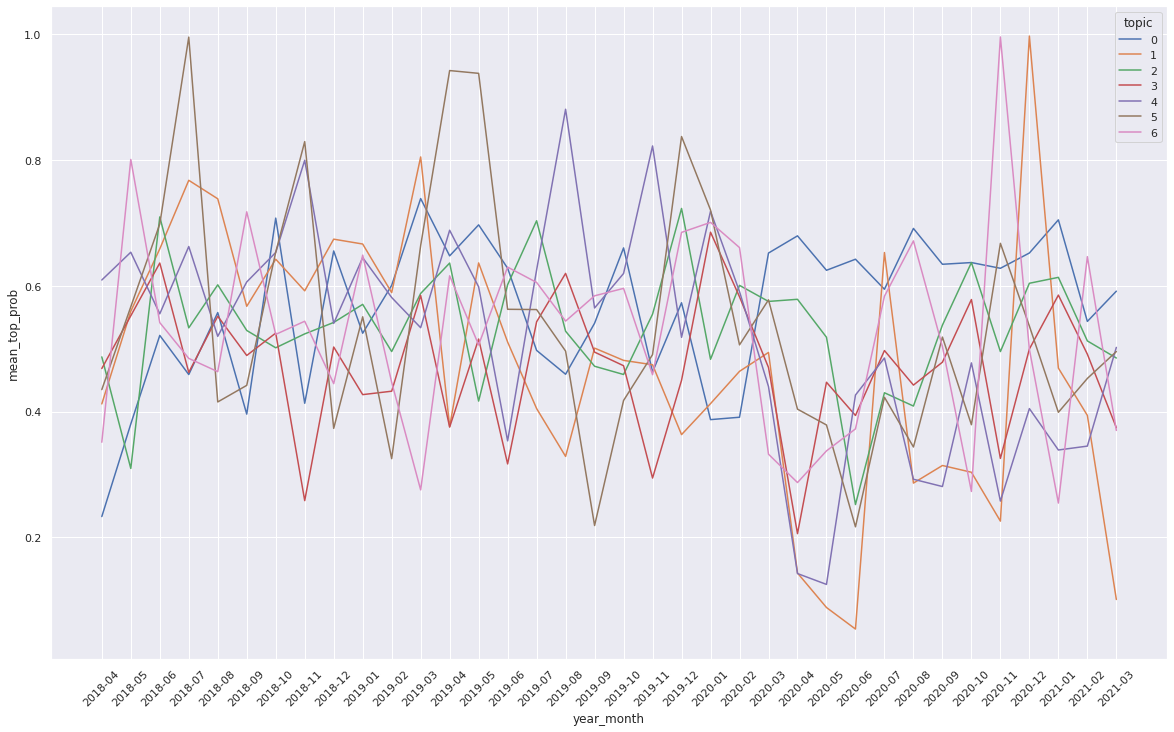

In [55]:
# Visualize topics over time

#viz_set = df_topictime.loc[df_topictime['topic'].isin([5, 13, 0]), :]
viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [56]:
# Dominant topic

idx = df_topiclong.groupby(['url'])['topic_prob'].transform('max') == df_topiclong['topic_prob']

#df_topiclong.groupby(['url'])['topic_prob'].transform('max')
df_domtop = df_topiclong[idx]

df_domtop.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob,post_month,post_year,year_month
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.9978296)",0,0.997830,12,2020,2020-12
2,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(2, 0.5605425)",2,0.560543,12,2020,2020-12
3,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",2020-12-03,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(0, 0.9983259)",0,0.998326,12,2020,2020-12
4,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",2020-12-03,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(2, 0.5536471)",2,0.553647,12,2020,2020-12
6,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",2020-12-02,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(2, 0.72169816)",2,0.721698,12,2020,2020-12


In [57]:
# Topics over time

df_topictime_grouped = df_domtop.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index()
df_topictime['topic'] = df_topictime['topic'].astype('category')

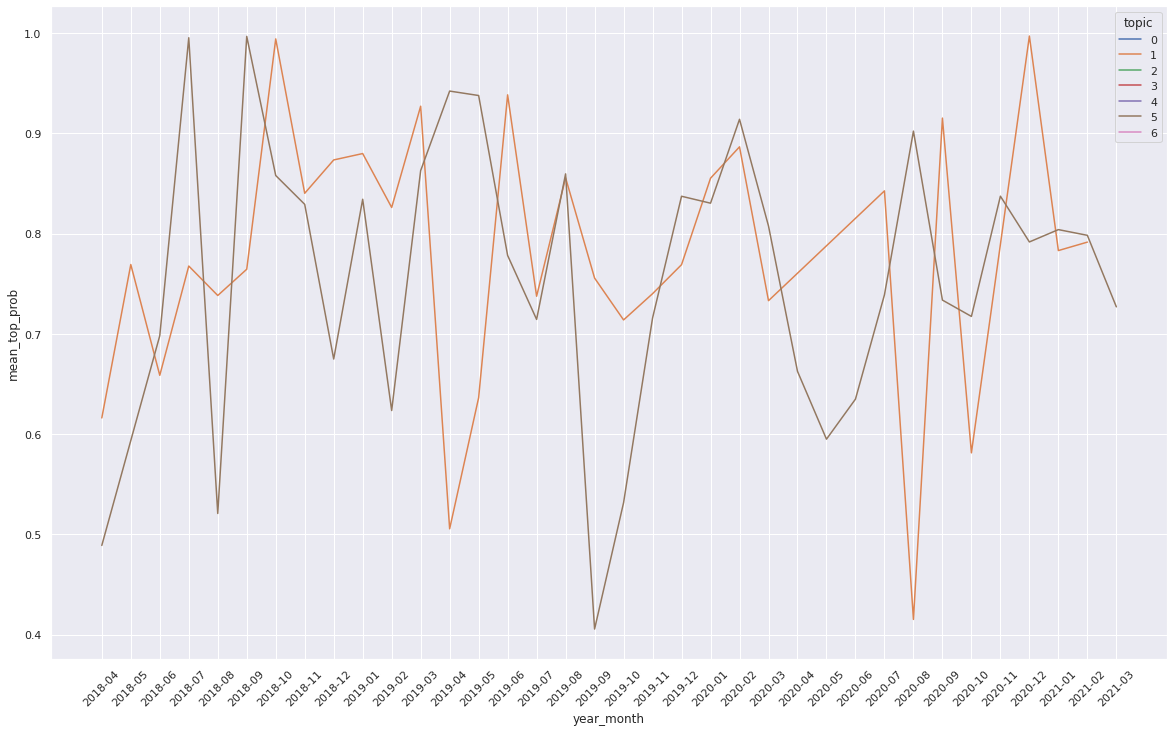

In [63]:
# Visualize topics over time

viz_set = df_topictime.loc[df_topictime['topic'].isin([1, 5]), :]
#viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [69]:
monthcounts = df_domtop.groupby(['year_month']).size().to_frame(name = "monthcount").reset_index()
df_tmcounts = df_topictime_grouped.size().to_frame(name = 'count').reset_index().merge(monthcounts, on = "year_month")
df_tmcounts['topic_pct'] = df_tmcounts['count'] / df_tmcounts['monthcount']

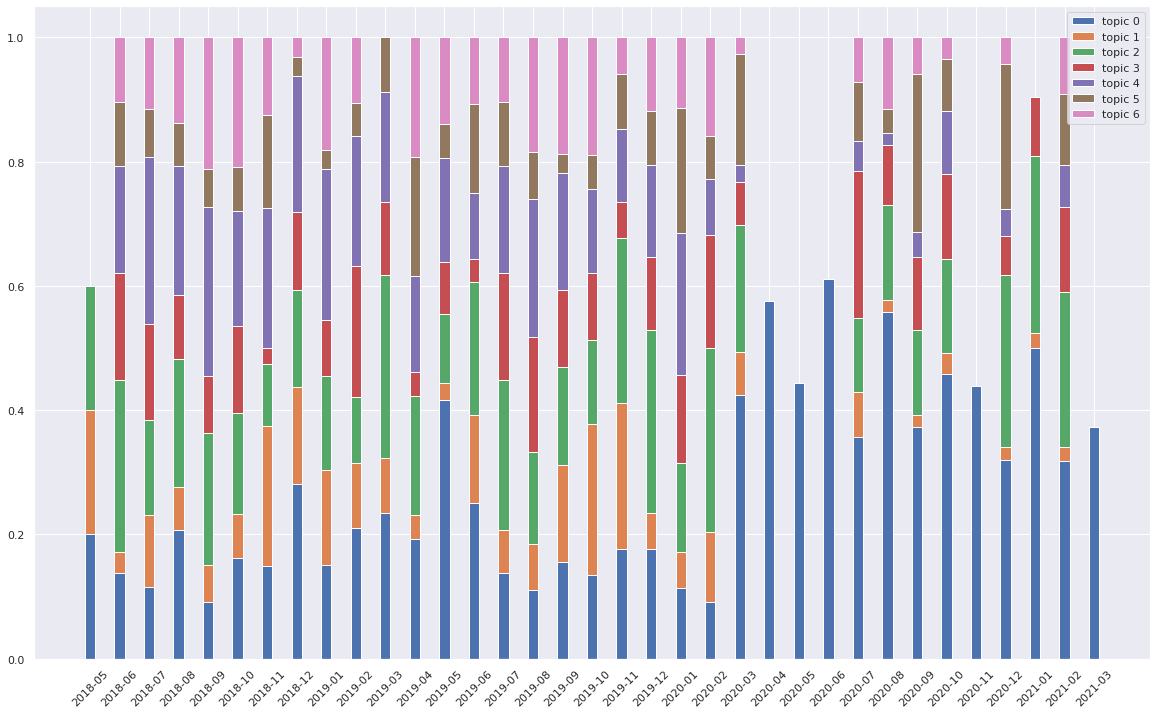

In [123]:
# With matplotlib (does not work)
fig, ax = plt.subplots()

for topic in range(7):
    subset = df_tmcounts.loc[df_tmcounts['topic'] == topic].sort_values('year_month')
    if topic > 0:
        subset = subset.merge(previous, on = "year_month")
        ax.bar(subset['year_month'], subset['topic_pct'], 0.35, label = f"topic {topic}", bottom = subset['pre_pct'])
        subset['topic_pct'] = subset['topic_pct'] + subset['pre_pct']
    else:
        ax.bar(subset['year_month'], subset['topic_pct'], 0.35, label = f"topic {topic}")
        
    previous = subset
    previous['pre_pct'] = previous['topic_pct']
    previous = previous.loc[:, ['year_month', 'pre_pct']]

ax.legend()
plt.xticks(rotation = 45)
plt.show()

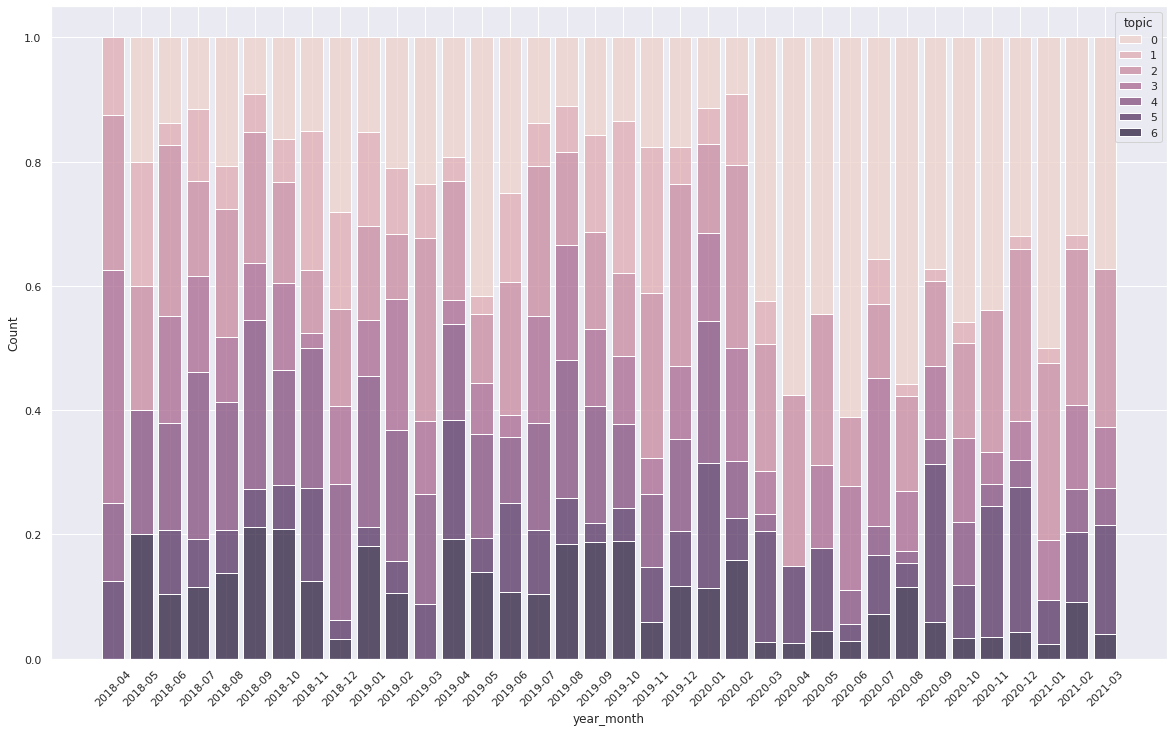

In [129]:
# With seaborn histplot. Does work but it is not a histogram!
sns.histplot(
    df_tmcounts,
    x='year_month',
    weights='topic_pct',
    hue='topic',
    multiple='stack',
    edgecolor='white',
    shrink=0.8
)

plt.xticks(rotation = 45)
plt.show()

In [148]:
import plotnine
from plotnine import *

%matplotlib inline
plotnine.options.figure_size = (20,12)

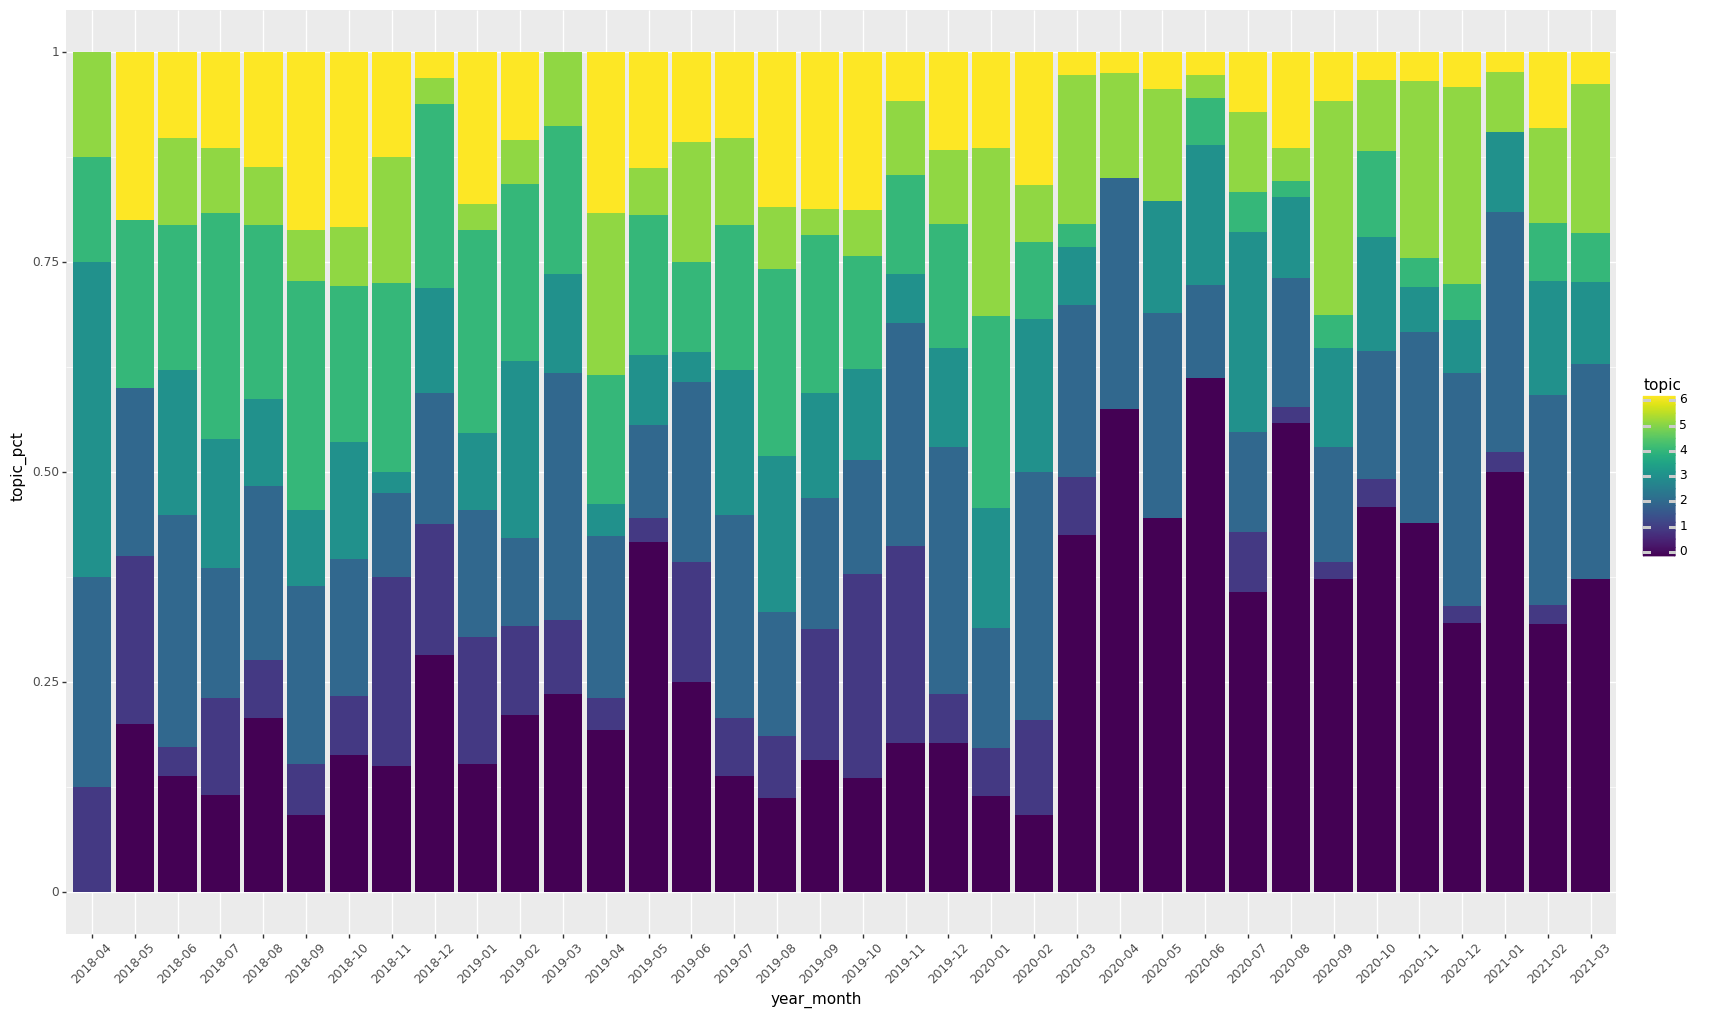

<ggplot: (8752959344689)>

In [149]:
# Plotnine/ggplot - easy and works!

(
    ggplot(df_tmcounts) 
    + geom_col(aes(x='year_month', y = 'topic_pct', fill='topic'))
    + theme(axis_text_x = element_text(angle = 45))
)

In [62]:
list(df_domtop.loc[df_domtop['topic'] == 1, :].sort_values('topic_prob')['url'].head(10))

['https://horesta.dk/nyheder/2020/marts/indbetaling-til-da-barsel-bliver-udskudt/?_requestTag=',
 'https://horesta.dk/nyheder/2019/oktober/video-forudbestil-horestas-nye-hotelanalyse/?_requestTag=',
 'https://horesta.dk/nyheder/2020/august/baeredygtig-turismesatsning-paa-tvaers-af-landet-tre-organisationer-faar-tildelt-green-tourism-organization/?_requestTag=',
 'https://horesta.dk/nyheder/2020/oktober/nu-er-det-igen-tid-til-at-planlaegge-julen/?_requestTag=',
 'https://horesta.dk/nyheder/2020/februar/samraad-erhvervsskatteordfoerer-vil-droefte-mulig-aendring-af-udskaeldt-afgift/?_requestTag=',
 'https://horesta.dk/nyheder/2018/august/skal-du-med-til-messe-og-inspirerende-branchearrangement/?_requestTag=',
 'https://horesta.dk/nyheder/2019/oktober/hvordan-bliver-jeres-mad-mere-baeredygtig-og-klimavenlig-ogsaa-med-koed-paa-menuen/?_requestTag=',
 'https://horesta.dk/nyheder/2019/september/blog-tak-for-invitationen-mette-frederiksen/?_requestTag=',
 'https://horesta.dk/nyheder/2019/april